In [5]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

#Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

#WordCloud
from wordcloud import WordCloud, get_single_color_func
from os import path
from PIL import Image

# n-grams
from collections import defaultdict



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
import os



df_train= pd.read_csv('data.csv')
print(df_train.shape)
df_train.head()



(1539, 9)


,Unnamed: 0,title,rating,name,num_ratings,num_reviews,num_followers,synopsis,genre
0,0,Sapiens: A Brief History of Humankind,4.39,Yuval Noah Harari,"8,06,229","46,149",30.5k,"100,000 years ago, at least six human species ...",history
1,1,"Guns, Germs, and Steel: The Fates of Human Soc...",4.04,Jared Diamond,"3,67,056","12,879","6,538","""Diamond has written a book of remarkable scop...",history
2,2,A People's History of the United States,4.07,Howard Zinn,"2,24,620","6,509","2,354","In the book, Zinn presented a different side o...",history
3,3,"The Devil in the White City: Murder, Magic, an...",3.99,Erik Larson,"6,13,157","36,644",64.2k,Author Erik Larson imbues the incredible event...,history
4,4,The Diary of a Young Girl,4.18,Anne Frank,"33,13,033","35,591","4,621",Discovered in the attic in which she spent the...,history


In [7]:
text = " This is a message to be cleaned. It may involve some things like: , ?, :, ''  adjacent spaces, tabs, .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    
    return text

text=preprocess(text)
print(text)  #text is a string



def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

text=stopword(text)
print(text)

this is a message to be cleaned it may involve some things like adjacent spaces tabs
message cleaned may involve things like adjacent spaces tabs


In [8]:
def finalpreprocess(string):
    return stopword(preprocess(string))

df_train['clean_text'] = df_train['synopsis'].apply(lambda x: finalpreprocess(x))
df_train.head()
with open('cleansedData.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(df_train, f, pickle.HIGHEST_PROTOCOL)



 # Load nedenstående pickle cleansed data


In [9]:
with open('cleansedData.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    df_train = pickle.load(f)
display(df_train)

,Unnamed: 0,title,rating,name,num_ratings,num_reviews,num_followers,synopsis,genre,clean_text
0,0,Sapiens: A Brief History of Humankind,4.39,Yuval Noah Harari,"8,06,229","46,149",30.5k,"100,000 years ago, at least six human species ...",history,years ago least six human species inhabited ea...
1,1,"Guns, Germs, and Steel: The Fates of Human Soc...",4.04,Jared Diamond,"3,67,056","12,879","6,538","""Diamond has written a book of remarkable scop...",history,diamond written book remarkable scope one impo...
2,2,A People's History of the United States,4.07,Howard Zinn,"2,24,620","6,509","2,354","In the book, Zinn presented a different side o...",history,book zinn presented different side history tra...
3,3,"The Devil in the White City: Murder, Magic, an...",3.99,Erik Larson,"6,13,157","36,644",64.2k,Author Erik Larson imbues the incredible event...,history,author erik larson imbues incredible events su...
4,4,The Diary of a Young Girl,4.18,Anne Frank,"33,13,033","35,591","4,621",Discovered in the attic in which she spent the...,history,discovered attic spent last years life anne fr...
...,...,...,...,...,...,...,...,...,...,...
1534,1534,Hounded,4.09,Kevin Hearne,"83,827","7,203","11,905","Atticus O’Sullivan, last of the Druids, lives ...",fantasy,atticus osullivan last druids lives peacefully...
1535,1535,Charlie and the Chocolate Factory,4.15,Roald Dahl,"7,75,001","14,252","22,897",Charlie Bucket's wonderful adventure begins wh...,fantasy,charlie bucket wonderful adventure begins find...
1536,1536,Red Rising,4.25,Pierce Brown,"3,10,138","30,388","30,510","""I live for the dream that my children will be...",fantasy,live dream children born free says like land f...
1537,1537,Frostbite,4.26,Richelle Mead,"3,37,538","12,435","66,448","Rose loves Dimitri, Dimitri might love Tasha, ...",fantasy,rose loves dimitri dimitri might love tasha ma...


# Vectors

In [10]:
## SKRIV HVOR VI HAR DETTE FRA



# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


In [19]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["genre"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

## Confusion Matrix

In [20]:
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n' ,confusion_matrix(y_predict, y_val))
 
  

                 precision    recall  f1-score   support

        fantasy       0.72      0.81      0.76        68
        history       0.80      0.63      0.71        19
         horror       0.75      0.20      0.32        15
     psychology       1.00      0.82      0.90        17
        romance       0.29      0.10      0.15        20
        science       1.00      0.85      0.92        13
science_fiction       1.00      0.33      0.50         9
         sports       1.00      0.38      0.55        21
       thriller       0.64      0.97      0.77       103
         travel       0.93      0.57      0.70        23

       accuracy                           0.72       308
      macro avg       0.81      0.57      0.63       308
   weighted avg       0.74      0.72      0.69       308

Confusion Matrix: 
 [[ 55   0   1   0   7   2   4   0   2   5]
 [  0  12   0   0   0   0   0   1   0   2]
 [  0   0   3   0   0   0   0   0   1   0]
 [  0   0   0  14   0   0   0   0   0   0]
 [  2  

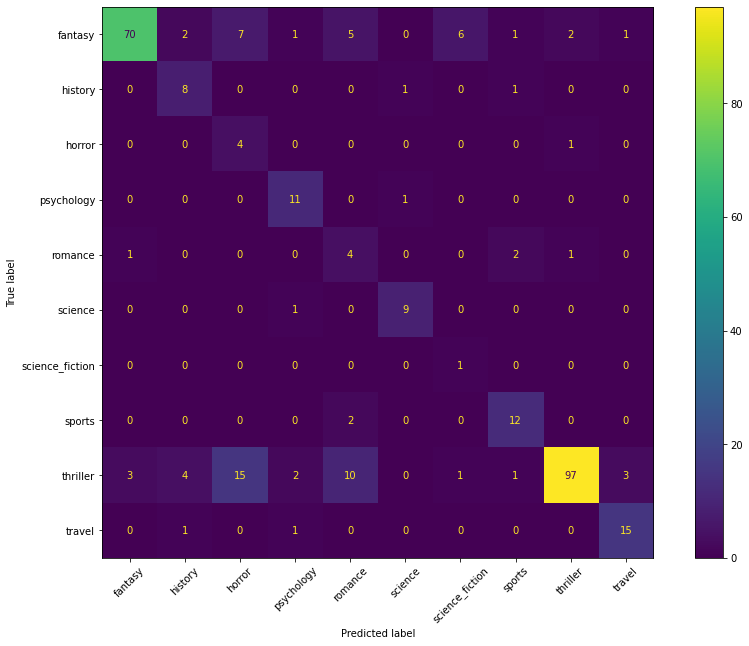

In [107]:
ConfusionMatrixDisplay.from_predictions(y_predict,y_val)  
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=(0,0,2.1,2.1));
plt.savefig('ConfusionMatrix.pdf',bbox_inches='tight')
plt.xticks(rotation=45)
plt.show()

